In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score,roc_curve, auc
import joblib
from sklearn.pipeline import Pipeline


В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [2]:
df = pd.read_csv('train.csv',index_col='id')

In [3]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [3]:
target_col = 'Exited'
input_cols = [col for col in df.columns if col not in ["id", "CustomerId", "Surname", target_col]]

In [4]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df[target_col], random_state=42)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [5]:
train_inputs = train_df[input_cols].copy()
val_inputs = val_df[input_cols].copy()

train_targets = train_df[target_col].copy()
val_targets = val_df[target_col].copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [6]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [7]:
numeric_cols

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [8]:
categorical_cols

['Geography', 'Gender']

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [14]:
df[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,658.94,37.74,5.03,42729.79,1.59,0.79,0.49,117784.67
std,72.26,8.22,2.78,59727.31,0.53,0.41,0.50,45734.45
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83058.14
50%,662.00,37.00,5.00,0.00,2.00,1.00,0.00,123584.87
75%,708.00,42.00,7.00,109531.02,2.00,1.00,1.00,156884.70
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [17]:
df[numeric_cols].isna().any()

,0
CreditScore,False
Age,False
Tenure,False
Balance,False
NumOfProducts,False
HasCrCard,False
IsActiveMember,False
EstimatedSalary,False


In [9]:
scaler = StandardScaler()

In [10]:
train_inputs[numeric_cols] = scaler.fit_transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [11]:
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.15,-2.42,-1.81,-0.72,-1.11,-1.94,-0.98,-2.59
25%,-0.77,-0.70,-0.73,-0.72,-1.11,0.52,-0.98,-0.76
50%,0.03,-0.08,-0.01,-0.72,0.77,0.52,-0.98,0.12
75%,0.68,0.53,0.71,1.12,0.77,0.52,1.02,0.85
max,2.64,4.46,1.79,2.78,4.52,0.52,1.02,1.80


In [23]:
df[categorical_cols].nunique()

,0
Geography,3
Gender,2


In [12]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop='first')

In [14]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [15]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [16]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])

In [17]:
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [18]:
display(train_inputs.head(),val_inputs.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
id,,,,,,,,,,,,,
7180,0.320187,France,Male,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,0.0,0.0,1.0
10393,0.347838,France,Female,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,0.0,0.0,0.0
80,0.638166,Germany,Male,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,1.0,0.0,1.0
3365,0.140460,Spain,Male,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,1.0,1.0
12236,0.665816,France,Male,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,0.0,0.0,1.0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
id,,,,,,,,,,,,,
6490,0.762592,Germany,Male,1.021379,-1.447264,1.214543,4.524299,0.515062,1.016977,-0.988144,1.0,0.0,1.0
3646,-0.910252,France,Male,0.406985,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.750392,0.0,0.0,1.0
5306,0.997620,France,Female,0.038348,-1.087792,-0.717950,0.769304,-1.941514,1.016977,-0.022404,0.0,0.0,0.0
652,0.195761,France,Female,0.652742,-0.368848,1.881867,-1.108193,-1.941514,1.016977,-0.139723,0.0,0.0,0.0
2627,0.264887,Spain,Female,-0.944682,-0.368848,-0.717950,0.769304,0.515062,-0.983306,0.563519,0.0,1.0,0.0


**опис**
1. Масштабувала дані, щоб отримати рівномірну пропорцію впливу на модель
2. нема пустих значень - тому і не використовувала заповнення
3. Колонки `Geography` та `Gender`закодувала за допомогою OneHotEncoder, оскльки там всього 3 - 2 категорії відповідно, але немає між ними залежності, і відкинула першу категорію щоб не виникало потім мультиколеніарність

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [19]:
!pip install pyarrow --quiet

In [20]:
train_inputs.to_parquet('train_input.parquet')
val_inputs.to_parquet('val_input.parquet')

pd.DataFrame(train_targets).to_parquet('train_target.parquet')
pd.DataFrame(val_targets).to_parquet('val_target.parquet')

In [48]:
!ls

sample_data  train_input.parquet   val_input.parquet
train.csv    train_target.parquet  val_target.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [21]:
processed_cols = numeric_cols + list(encoded_cols)

In [22]:
X_train = train_inputs[processed_cols]
X_val = val_inputs[processed_cols]

In [53]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
id,,,,,,,,,,,
7180,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,0.0,0.0,1.0
10393,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,0.0,0.0,0.0
80,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,1.0,0.0,1.0
3365,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,1.0,1.0
12236,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,0.0,0.0,1.0


In [53]:
model = LogisticRegression(solver='liblinear',max_iter=1000,random_state=42)

In [54]:
model.fit(X_train, train_targets)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [55]:
y_train_probs = model.predict_proba(X_train)[:, 1]
y_val_probs = model.predict_proba(X_val)[:, 1]

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [56]:
y_train_preds = (y_train_probs >= 0.5).astype(int)
y_val_preds = (y_val_probs >= 0.5).astype(int)

In [57]:
confusion_matrix(train_targets, y_train_preds, normalize='true')

array([[0.95794099, 0.04205901],
       [0.45167895, 0.54832105]])

In [58]:
confusion_matrix(val_targets, y_val_preds, normalize='true')

array([[0.94686192, 0.05313808],
       [0.43278689, 0.56721311]])

In [61]:
roc_curve(train_targets, y_train_probs)

(array([0.        , 0.        , 0.        , ..., 0.99288554, 1.        ,
        1.        ]),
 array([0.00000000e+00, 4.09500410e-04, 2.86650287e-03, ...,
        9.99590500e-01, 9.99590500e-01, 1.00000000e+00]),
 array([       inf, 0.99390657, 0.9898921 , ..., 0.00260264, 0.00118441,
        0.00114627]))

In [59]:
f1_score(train_targets, y_train_preds)

0.6402103753287115

In [60]:
f1_score(val_targets, y_val_preds)

0.6389658356417359

In [32]:
def compute_auroc_and_build_roc(targets,y_pred_proba, name=''):
  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


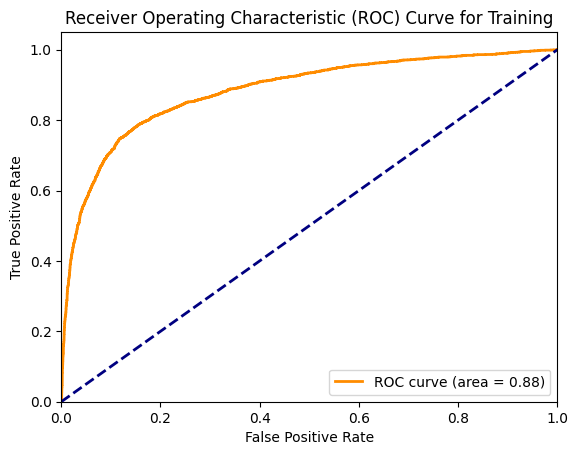

In [61]:
compute_auroc_and_build_roc(train_targets, y_train_probs, 'Training')


AUROC for Validation: 0.88


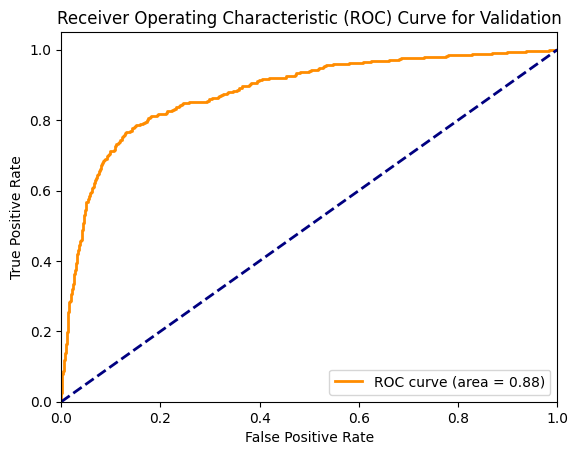

In [62]:
compute_auroc_and_build_roc(val_targets, y_val_probs, 'Validation')

**Якість моделі**

Досить близька до дуже хорошого результату, оскільки AUROC - 0.88, що для тренувальної що і для валідаційних даних. Однак все ще не ідеальна

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [35]:
def all_no(inputs):
    return np.full(len(inputs), 0)

In [36]:
accuracy_train_model = accuracy_score(train_targets, y_train_preds)
accuracy_val_model = accuracy_score(val_targets, y_val_preds)

accuracy_train_no = accuracy_score(train_targets, all_no(train_inputs))
accuracy_val_no = accuracy_score(val_targets, all_no(val_inputs))

In [37]:
print("Accuracy of Logistic Regression TRAIN: {:.2f}%".format(accuracy_train_model * 100))
print("Accuracy of Logistic Regression VAL: {:.2f}%".format(accuracy_val_model * 100))
print("Accuracy of '0-class' TRAIN: {:.2f}%".format(accuracy_train_no * 100))
print("Accuracy of '0-class' VAL: {:.2f}%".format(accuracy_val_no * 100))

Accuracy of Logistic Regression TRAIN: 87.46%
Accuracy of Logistic Regression VAL: 86.97%
Accuracy of '0-class' TRAIN: 79.65%
Accuracy of '0-class' VAL: 79.67%


**Якість моделі**

Якщо порівнювати з моделю,яка заповнює мажоритарним класом, то модель з п.6 краще справляється з цим.
Хоча хотілось б більшої різниці між ними :)

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [38]:
log_reg = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [39]:
joblib.dump(log_reg, 'log_reg.joblib')

['log_reg.joblib']

In [40]:
model_2 = joblib.load('log_reg.joblib')

In [41]:
test_preds2 = log_reg['model'].predict(X_train)
accuracy_score(train_targets, test_preds2)

0.8745833333333334

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [44]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [45]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, df[:5])

array([0.00566261, 0.03348764, 0.38194179, 0.37942694, 0.97915309])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [46]:
test_raw_df = pd.read_csv('test.csv')

In [47]:
predict_test = predict_raw_df(scaler,encoder,numeric_cols,categorical_cols,test_raw_df)
predict_test

array([0.06928864, 0.0334286 , 0.15391187, ..., 0.01665942, 0.1530399 ,
       0.08827192])

In [48]:
test_raw_df['Exited'] = predict_test

In [49]:
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Exited
0,15000,15594796.0,Chu,-1.034678,Germany,Male,-0.944682,-1.087792,1.720173,-1.108193,0.515062,1.016977,0.875226,1.0,0.0,1.0,0.069289
1,15001,15642821.0,Mazzi,-1.490909,France,Male,0.161227,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.109098,0.0,0.0,1.0,0.033429
2,15002,15716284.0,Onyekachi,0.651991,France,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,-0.983306,0.850584,0.0,0.0,1.0,0.153912
3,15003,15785078.0,Martin,0.804068,Spain,Male,0.898500,-0.728320,-0.717950,-1.108193,0.515062,1.016977,1.073044,0.0,1.0,1.0,0.198257
4,15004,15662955.0,Kenechukwu,-0.924077,Spain,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,1.016977,0.563521,0.0,1.0,1.0,0.054051


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [50]:
sample_df = pd.read_csv('sample_submission.csv')

In [ ]:
sample_df

,Exited
id,
15000,0.5
15001,0.5
15002,0.5
15003,0.5
15004,0.5
...,...
24995,0.5
24996,0.5
24997,0.5


In [51]:
sample_df.Exited = sample_df.index.map(test_raw_df.Exited)
sample_df.head()

,id,Exited
0,15000,0.069289
1,15001,0.033429
2,15002,0.153912
3,15003,0.198257
4,15004,0.054051


In [52]:
sample_df.to_csv('submission_log_reg.csv',index=False)